## SPH simulations

In this demo we aim to roughly reproduce the simulations in Bate et al. (2003) (http://articles.adsabs.harvard.edu/pdf/2003MNRAS.339..577B).

We set up a molecular cloud and add the particles to the Fi SPH code.

We then evolve this for ~ a free fall time, and form sink particles when the density reaches a specified value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from amuse.datamodel import Particles, Particle, new_regular_grid
from amuse.units import nbody_system, units, constants

from amuse.ext.molecular_cloud import molecular_cloud

from amuse.community.fi.interface import Fi
from amuse.community.ph4.interface import ph4

from amuse.couple.bridge import Bridge

Set up the gas: create a molecular cloud (similar to Bate et al. 2003, but with fewer particles)

In [2]:
Ngas = 10000
Mcloud = 50. | units.MSun
Rcloud = 0.375/2 | units.parsec
converter = nbody_system.nbody_to_si(Mcloud, Rcloud)
gas = molecular_cloud(targetN=Ngas,
                      convert_nbody=converter, 
                      seed=12122019,
                      ethep_ratio=0.01, 
                      ekep_ratio=1.,
                      power=-4).result

In [3]:
rho_cloud = 3*Mcloud/(4*np.pi*Rcloud**3)
mu = 2.33 | units.amu
print("Cloud Mass = {:02.1e}[MSun]".format(Mcloud.value_in(units.MSun)))
print("Mean density = {:f}[nH.cm^-3]".format((rho_cloud/mu).value_in(units.cm ** -3)))
# rhoh3 = (6 / np.pi * ic.M / Ngas)
# ic.eps = (rhoh3 / 100 / rho_cloud) ** (1 / 3)

tff = np.sqrt(3. * np.pi / (32. * constants.G * rho_cloud))
print("Free-fall time = ", tff)

Cloud Mass = 5.0e+01[MSun]
Mean density = 31683.876670[nH.cm^-3]
Free-fall time =  0.1901[Myr]


Set up the SPH code "Fi". We set it to run in isothermal mode (default is adiabatic), and with OpenMP parallellisation. Fi uses a fixed timestep, which we set to 0.001 times the free fall timestep.

In [7]:
sph = Fi(converter, mode="openmp")
sph.gas_particles.add_particles(gas)

sph.parameters.gamma = 1.  # default value: 1.6666667
sph.parameters.isothermal_flag = True
sph.parameters.integrate_entropy_flag = False

sph.parameters.epsilon_squared = (0.05 | units.parsec)**2
sph.parameters.eps_is_h_flag = True

sph.parameters.timestep = tff/100

Fi supports stopping conditions, which can break the "evolve" loop when this condition is detected. We enable stopping conditions for high densities, and stop when the density of a gas particle exceeds a specified density.

In [8]:
sph.parameters.stopping_condition_maximum_density = 1e-13 | units.g * units.cm**-3
density_limit_detection = sph.stopping_conditions.density_limit_detection
density_limit_detection.enable()

We also set up gravity and Bridge, and add the systems.

We add a few initial stars to ph4, since it doesn't like running without any particles!

In [9]:
initial_stars = Particles(2)
initial_stars.position = [[0.25, 0.4, 0], [-0.25, -0.4, 0]] | units.parsec
initial_stars.velocity = [[-0.8, -0.5, 1], [0.8, 0.5, -1]] | units.parsec * units.Myr**-1
initial_stars.mass = 0.5 | units.MSun

gravity = ph4(converter)
gravity.parameters.epsilon_squared = (0.05 | units.parsec)**2
gravity.parameters.force_sync = 1
gravity.particles.add_particles(initial_stars)

system = Bridge()
system.timestep = 2*sph.parameters.timestep
system.add_system(sph, (gravity,))
system.add_system(gravity, (sph,))

We define two functions for making plots of the gas density. Counting individual gas particles would not be correct here, since SPH is a smoothed particle method!

In [10]:
def sph_to_grid(sph_code, view=[-1., 1., -1., 1., 0, 0] | units.pc,
                grid_size=(64, 64, 1)):
    """
    Interpolate SPH representation on a defined cartesian grid
    :param sph_code: sph code to make the interpolation of the sph representation
    :param view: the (physical) region to sample [xmin, xmax, ymin, ymax, zmin, zmax] | units
    :param grid_size:  discretisation of the cube in pixels (x, y, z)
    :return: density map (array of shape grid_size),
             velocity maps (3 arrays of shape grid_size)
             length of cells in each direction (array in amuse units)
    """

    shape = (grid_size[0], grid_size[1], grid_size[2])
    size1D = grid_size[0] * grid_size[1] * grid_size[2]
    axis_lengths = [0.0, 0.0, 0.0] | units.pc
    axis_lengths[0] = view[1] - view[0]
    axis_lengths[1] = view[3] - view[2]
    axis_lengths[2] = view[5] - view[4]
    grid = new_regular_grid(shape, axis_lengths)
    grid.x += view[0]
    grid.y += view[2]
    grid.z += view[4]
    speed = grid.z.reshape(size1D) * (0 | 1 / units.s) #convert into speed units

    rho, rhovx, rhovy, rhovz, rhoe = \
        sph_code.get_hydro_state_at_point(grid.x.reshape(size1D),
                                          grid.y.reshape(size1D),
                                          grid.z.reshape(size1D),
                                          speed, speed, speed)
    vx = rhovx / rho
    vy = rhovy / rho
    vz = rhovz / rho
    rho = rho.reshape(shape)
    vx = vx.reshape(shape)
    vy = vy.reshape(shape)
    vz = vz.reshape(shape)
    # physical size of each cells
    cells_length = [axis_lengths[i] / grid_size[i] for i in range(3)]

    return rho, (vx, vy, vz), cells_length


def plot_hydro(rho, extent, time=0|units.Myr, vmin=None, vmax=None, stars=None, ax=None):
    """
    Plot 2D density map in logarithmic scale
    :param rho: density map to plot
    :param extent: physical limits of the plot [xmin, xmax, ymin, ymax] | units
    :param time: time of the snapshot
    :param vmin: sets the minimum density value
    :param vmax: sets the maximum density value
    :param stars: particle set to superimpose their position on the plot
    :return: matplotlib's fig and ax
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    rho[rho == 0] = np.nan
    im = ax.imshow(np.log10(rho.T),
                   extent=extent.value_in(units.pc),
                   origin="lower",
                   vmin=vmin, vmax=vmax
                   )

    if ax is None:
        cbar = plt.colorbar(im)
        cbar.set_label('density [$cm^-3$]', rotation=270)
    
    if stars and not stars.is_empty():
        ax.scatter(
                stars.x.value_in(units.pc),
                stars.y.value_in(units.pc),
                s=10*stars.mass.value_in(units.MSun),
                edgecolors=None,
                color="w",
        )
    ax.set_title("Molecular cloud density at time={:4.3f}Myr".format(time.value_in(units.Myr)))
    ax.set_xlabel("x [pc]")
    ax.set_xlim(extent.value_in(units.pc)[:2])
    ax.set_ylabel("y [pc]")
    ax.set_ylim(extent.value_in(units.pc)[-2:])
    return ax


def log_gas(sph, E0=None):
    """
    Print energy log for hydro simulation
    :param sph: hydro code running
    :param E0: Total energy at prvious timestep
    :return kinetic, potential and thermal energies
    """

    Ekin = sph.unit_converter.to_nbody(sph.kinetic_energy)
    Epot = sph.unit_converter.to_nbody(sph.potential_energy)
    Eth = sph.unit_converter.to_nbody(sph.thermal_energy)
    Egas = Ekin + Epot + Eth
    Qgas = (Ekin+Eth)/-Epot

    dE = (Egas - E0) / np.abs(E0) if E0 else 0
    print("time = {:.3f} [Myr], M = {:.3f} [MSun]"
          .format(sph.get_time().value_in(units.Myr),
                  sph.gas_particles.mass.sum().value_in(units.MSun)))
    print("dE = {:.3f}, Qgas = {:.3f}, Ekin/|Epot| = {}".format(dE, Qgas,
                                                                Ekin/-Epot))
    return Ekin, Epot, Eth


We also define an "evolve" function, which takes the stopping conditions into account. 

When a high density is detected, the high density gas is converted to "sink" particles.

In [12]:
def accrete_gas(sink, gas, accretion_radius=150 | units.AU):
    accreted_gas = gas[(gas.position - sink.position).lengths() < accretion_radius]
    return accreted_gas

def evolve_model(system, sph, gravity, time_end):
    nb_sink = 0
    time = system.model_time
    while time <= (time_end - 0.5 * system.timestep):
        time += system.timestep
        system.evolve_model(time)

        # If there is high-density gas, form a sink from the densest particle,
        # the following condition stop the computation and we create a sink particle
        density_limit_detection = sph.stopping_conditions.density_limit_detection
        density_limit_detection.enable()
        while density_limit_detection.is_set():
#             print("max density: {4.3e}".format(max(sph.gas_particles.density).value_in(units.g/units.cm**3)))
            nb_sink = nb_sink+1
            # Identify the sink
            sink_core = sph.gas_particles[sph.gas_particles.density == max(sph.gas_particles.density)][0]

            # Create it
            sink = Particle()
            sink.position = sink_core.position
            sink.velocity = sink_core.velocity

            #Accrete all gas around in a given radius
            accreted_gas = accrete_gas(sink, sph.gas_particles)
            
            #Update properties of the sink
            sink.position = accreted_gas.center_of_mass()
            sink.velocity = accreted_gas.center_of_mass_velocity()
            sink.mass = accreted_gas.total_mass()
            
            #Remove gas_particles and add new born star
            sph.gas_particles.remove_particles(accreted_gas)
            gravity.particles.add_particle(sink)
            print("Sink created at t=%s" % time.in_(units.Myr))
#             print("max density: {4.3e}".format(max(sph.gas_particles.density).value_in(units.g/units.cm**3)))
            
            #Contine evolving
            sph.evolve_model(time)

    # Accrete matter onto the sink particles
    for sink in gravity.particles:
        accreted_gas = accrete_gas(sink, sph.gas_particles)
        if not accreted_gas.is_empty:
            agm = accreted_gas.mass
            mwp = sink.position * sink.mass
            mwv = sink.velocity * sink.mass
            for i in range(3):
                mwp[i] += (agm * accreted_gas.position[i]).sum()
                mwv[i] += (agm * accreted_gas.velocity[i]).sum()
            mass = sink.mass + accreted_gas.total_mass()
            sink.position = mwp / mass
            sink.velocity = mwv / mass
            sph.gas_particles.remove_particles(accreted_gas)
    if nb_sink:
        print("%i sinks formed in this step. Sinks are on average %s MSun"
              % (nb_sink, gravity.particles.mass.mean().value_in(units.MSun)))


We evolve and plot the system until a free fall time. You will notice it slows down as we reach higher densities for the gas! 

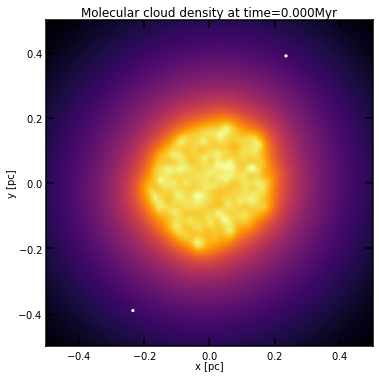

In [13]:
time = 0.1*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], stars=gravity.particles)

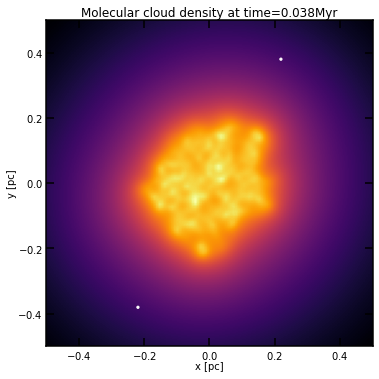

In [14]:
time = 0.2*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

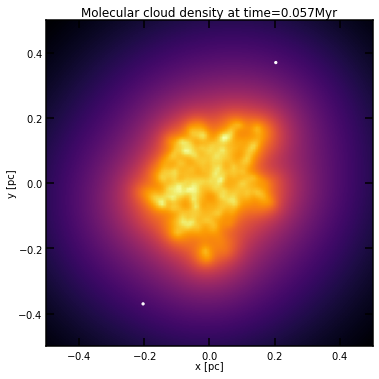

In [15]:
time = 0.3*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

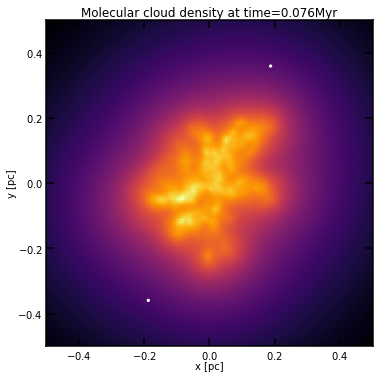

In [16]:
time = 0.4*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

In [ ]:
time = 0.5*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

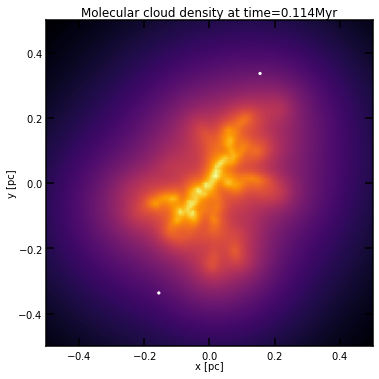

In [18]:
time = 0.6*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

In [19]:
time = 0.7*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

Sink created at t=0.1369[Myr]
Sink created at t=0.1445[Myr]
Sink created at t=0.1483[Myr]
Sink created at t=0.1521[Myr]
4 sinks formed in this step. Sinks are on average 0.235 MSun


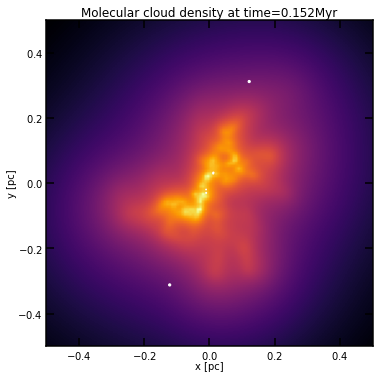

In [20]:
time = 0.8*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2invalid value encountered in true_divide]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

Sink created at t=0.1597[Myr]
Sink created at t=0.1635[Myr]
Sink created at t=0.1673[Myr]
Sink created at t=0.1711[Myr]
4 sinks formed in this step. Sinks are on average 0.173 MSun


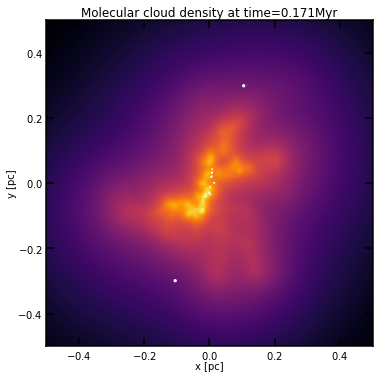

In [21]:
time = 0.9*tff
evolve_model(system, sph, gravity, time)

view=[-0.5, 0.5, -0.5, 0.5, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

In [22]:
time = 1.*tff
evolve_model(system, sph, gravity, time)

view=[-0.25, 0.25, -0.25, 0.25, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

Sink created at t=0.1749[Myr]
Sink created at t=0.1787[Myr]
Sink created at t=0.1787[Myr]
Sink created at t=0.1825[Myr]
Sink created at t=0.1825[Myr]
Sink created at t=0.1863[Myr]
Sink created at t=0.1901[Myr]
Sink created at t=0.1901[Myr]
8 sinks formed in this step. Sinks are on average 0.148055555556 MSun


In [23]:
time = 1.1*tff
evolve_model(system, sph, gravity, time)

view=[-0.25, 0.25, -0.25, 0.25, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

Sink created at t=0.1939[Myr]
Sink created at t=0.1939[Myr]
Sink created at t=0.1977[Myr]
Sink created at t=0.1977[Myr]
Sink created at t=0.2015[Myr]
Sink created at t=0.2015[Myr]
Sink created at t=0.2053[Myr]
Sink created at t=0.2053[Myr]
Sink created at t=0.2091[Myr]
Sink created at t=0.2091[Myr]
10 sinks formed in this step. Sinks are on average 0.136428571429 MSun


In [26]:
time = 1.2*tff
evolve_model(system, sph, gravity, time)

view=[-0.1, 0.1, -0.1, 0.1, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

Sink created at t=0.2129[Myr]
Sink created at t=0.2167[Myr]
Sink created at t=0.2167[Myr]
Sink created at t=0.2205[Myr]
Sink created at t=0.2205[Myr]
Sink created at t=0.2282[Myr]
Sink created at t=0.2282[Myr]
7 sinks formed in this step. Sinks are on average 0.140142857143 MSun


In [27]:
gravity.particles.mass.min()


quantity<0.05000[MSun]>

In [28]:
time = 2.*tff
evolve_model(system, sph, gravity, time)

view=[-0.1, 0.1, -0.1, 0.1, 0, 0] | units.pc
grid_size=(128, 128, 1)
rho, v, cells_length = sph_to_grid(sph, view, grid_size)
rho = (rho.sum(axis=2)/mu).value_in(units.cm**-3)
# rho = (rho.sum(axis=2) * cells_length[2]).value_in(units.amu / units.cm ** 2)
ax = plot_hydro(rho, view[:4], time, stars=gravity.particles)

Sink created at t=0.2320[Myr]
Sink created at t=0.2358[Myr]
Sink created at t=0.2358[Myr]
Sink created at t=0.2396[Myr]
Sink created at t=0.2396[Myr]
Sink created at t=0.2434[Myr]
Sink created at t=0.2434[Myr]
Sink created at t=0.2472[Myr]
Sink created at t=0.2472[Myr]
Sink created at t=0.2510[Myr]
Sink created at t=0.2510[Myr]
Sink created at t=0.2548[Myr]
Sink created at t=0.2548[Myr]
Sink created at t=0.2586[Myr]
Sink created at t=0.2586[Myr]
Sink created at t=0.2624[Myr]
Sink created at t=0.2624[Myr]
Sink created at t=0.2662[Myr]
Sink created at t=0.2662[Myr]
Sink created at t=0.2700[Myr]
Sink created at t=0.2700[Myr]
Sink created at t=0.2738[Myr]
Sink created at t=0.2738[Myr]
Sink created at t=0.2776[Myr]
Sink created at t=0.2814[Myr]
Sink created at t=0.2852[Myr]
Sink created at t=0.2852[Myr]
Sink created at t=0.2890[Myr]
Sink created at t=0.2890[Myr]
Sink created at t=0.2928[Myr]
Sink created at t=0.2928[Myr]
Sink created at t=0.2966[Myr]
Sink created at t=0.3004[Myr]
Sink creat

--------------------------------------------------------------------------
Primary job  terminated normally, but 1 process returned
a non-zero exit code. Per user-direction, the job has been aborted.
--------------------------------------------------------------------------
--------------------------------------------------------------------------
mpiexec detected that one or more processes exited with non-zero status, thus causing
the job to be terminated. The first process to do so was:

  Process name: [[1167,1],0]
  Exit code:    241
--------------------------------------------------------------------------


In [40]:
sph.stop()
gravity.stop()
system.stop()